Proces biznesowy, który będę analizować, pochodzi z sektora finansowego.**Dotyczy on podejmowania decyzji w sprawie akceptacji lub odrzucenia wniosku o wydanie karty kredytowej**. Sytuacja jest więc relatywnie prosta: potencjalny klient przychodzi do oddziału banku i składa wniosek. W oparciu o zestaw dostępnych cech ekspert (bądź system ekspercki) podejmuje decyzję, czy wydać kartę, czy też nie.

# Opis zbioru danych

Zbiór, który użyję, jest dostępny pod tym linkiem(http://archive.ics.uci.edu/ml/datasets/credit+approval). Zawiera on dane dotyczące 690 wniosków o wydanie karty kredytowej, wraz z decyzją: czy wniosek został zaakceptowany, czy też nie. Są to rzeczywiste dane, w których znajduje się łącznie 16 zmiennych. 15 z nich to **zmiennej objaśniające** (nazwane od A1 do A15). Są one cechami opisującymi osobę składającą wniosek, oraz (prawdopodobnie) danymi behawioralnymi (opisujące np. historią prowadzenia konta, wcześniejsze spłaty zobowiązań wobec banku, etc.).

Pewnie się zastanawiasz, jak chcę interpretować proces decyzyjny, skoro nie mam nazw zmiennych. Na potrzeby projektu przyjmę ich sztuczną interpretację, którą zaczerpnąłem z tej strony. Nazwy zmiennych zamieniam tak, by przypominały nazwy, z którymi można spotkać się w bankowości. Mam nadzieję, że wybaczysz mi ten zabieg. 

Jedną zmienną, którą zmieniłem w stosunku do tego, co jest widoczne na stronie, jest „ZipCode”, który u mnie będzie saldem konta. Zmienna przyjmuje 170 unikalnych wartości, z czego aż 132 wynoszą 0. Dodatkowo wykonałem analizę zależności zmiennej ze zmienną celu i uznałem, że „Saldo_konta” będzie tu bardziej pasować.

Po zamianie nazwy zmiennych, wraz z ich typami wyglądają następująco:

- Płeć – binarna,
- Wiek – ciągła,
- Zadłużenie – ciągła,
- Stan_cywilny – nominalna,
- Bank – nominalna,
- Wykształcenie – nominalna,
- Pochodzenie – nominalna,
- Lata_pracy – ciągła,
- Poz_hist_kred – binarna,
- Umowa_o_pracę – binarna,
- Score_kredytowy – ciągła,
- Prawo_jazdy – binarna,
- Obywatelstwo – nominalna,
- Saldo_konta – ciągła,
- Przychody – ciągła,
- Wynik – binarna.



Przed przystąpieniem do prac nam zbiorem muszę wymienić kilka założeń, które przyjąłem:

- Jako, że problem dotyczy sektora finansowego, do rozwiązania problemu użyję w pełni interpretowalnego algorytmu – drzewa decyzyjnego w wersji CART, z biblioteki Python sklearn.

- Interpretowalność odnosi się nie tylko do samego algorytmu, ale również do jego parametrów. Parametry algorytmu nie mogą utrudniać jego interpretacji. Drzewo nie powinno być zbyt głębokie.

- W interpretacji może przeszkodzić również zbyt duża liczba użytych zmiennych. Analiza głębokiego drzewa z kilkudziesięcioma zmiennymi może przypominać proces szukania z lupą najkrótszej drogi na mapie o dużej skali. W finalnym modelu powinno się znaleźć maksymalnie 10 – 15 zmiennych.

- Dane powinny być przetwarzane w taki sposób, aby możliwie jak najmniej przeszkadzało to w interpretacji osiągniętych wyników. Nie będę zatem wykonywać skomplikowanych transformacji zmiennych.

- Jakość modelu będę badał za pomocą dokładności predykcji (ang. Accuracy).

# Cel projektu 
Celem ogólnym projektu jest w jak najwyższym stopniu odwzorować proces decyzyjny odpowiadający za akceptację lub odrzucenie wniosku o wydanie karty kredytowej. Celem szczegółowym jest zbudowanie zestawu interpretowalnych reguł, które mogłoby automatyzować proces podejmowania decyzji biznesowej. W skrócie: będę starać się jak najlepiej odwzorowanie proces decyzyjny eksperta.

**Celem jakościowym jest osiągnięcie dokładności na poziomie 80% – 90%, przy zachowaniu odpowiedniej stabilności modelu**. Tę ostatnią będę badać podczas walidacji krzyżowej modelu. Będzie ona wyrażona w procentach i obliczana z pomocą wzoru: 
    - (odchylenie standardowe wyników Accuracy/średnia Accuracy) * 100.

## Wczytanie danych i niezbędnych bibliotek

In [274]:
# Podstawowe biblioteki
import pandas as pd
import numpy as np
# Podział zbioru, dobór parametrów modelu
from sklearn.model_selection import train_test_split, GridSearchCV
# Dobór zmiennych
from sklearn.feature_selection import RFE
# Walidacja zbioru
from sklearn.model_selection import cross_val_score
# Algorytm drzewa decyzyjnego
from sklearn.tree import DecisionTreeClassifier
# Badanie jakości modelu
from sklearn.metrics import accuracy_score
# Wizualizacja drzewa
from sklearn import tree
import graphviz

Zmiana precyzji wyświetlania liczb zmiennoprzecinkowych. Zamiast każdorazowo zaokrąglać, wystarczy jedna linijka kodu, dzięki której liczby będą wyświetlane w Pandas z precyzją do trzech miejsc po przecinku. Proste, a potrafi zaoszczędzić sporo czasu. 

In [275]:
pd.set_option('float_format', '{:.3f}'.format) 

Wczytuję teraz zbiór z pliku csv. To, co robię dodatkowo przy wczytywaniu, to parametrami wskazuję Pandas-owi:
- brak nagłówka w zbiorze,
- nazwy poszczególnych zmiennych,
- typy niektórych zmiennych,
- znak za pomocą którego oznaczone są braki w danych.

In [276]:
df = pd.read_csv('crx.data', 
                 header=None, 
                 names=['Płeć','Wiek','Zadłużenie','Stan_cywilny','Bank','Wykształcenie','Pochodzenie','Lata_pracy',
                        'Poz_hist_kred','Umowa_o_pracę','Score_kredytowy','Prawo_jazdy','Obywatelstwo','Saldo_konta',
                        'Przychody','Wynik'], 
                 decimal='.', 
                 na_values='?', 
                 dtype = {'Płeć':'category','Stan_cywilny':'category','Bank':'category','Wykształcenie':'category',
                          'Pochodzenie':'category','Poz_hist_kred':'category','Umowa_o_pracę':'category',
                          'Prawo_jazy':'category','Obywatelstwo':'category','Wynik':'category'})

In [277]:
df

,Płeć,Wiek,Zadłużenie,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Lata_pracy,Poz_hist_kred,Umowa_o_pracę,Score_kredytowy,Prawo_jazdy,Obywatelstwo,Saldo_konta,Przychody,Wynik
0,b,30.830,0.000,u,g,w,v,1.250,t,t,1,f,g,202.000,0,+
1,a,58.670,4.460,u,g,q,h,3.040,t,t,6,f,g,43.000,560,+
2,a,24.500,0.500,u,g,q,h,1.500,t,f,0,f,g,280.000,824,+
3,b,27.830,1.540,u,g,w,v,3.750,t,t,5,t,g,100.000,3,+
4,b,20.170,5.625,u,g,w,v,1.710,t,f,0,f,s,120.000,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.080,10.085,y,p,e,h,1.250,f,f,0,f,g,260.000,0,-
686,a,22.670,0.750,u,g,c,v,2.000,f,t,2,t,g,200.000,394,-
687,a,25.250,13.500,y,p,ff,ff,2.000,f,t,1,t,g,200.000,1,-
688,b,17.920,0.205,u,g,aa,v,0.040,f,f,0,f,g,280.000,750,-


Mając wczytany zbiór, sprawdzam jego rozmiar i podglądam, jak wyglądają poszczególne obserwacje, by sprawdzić, czy wszystko wczytało się prawidłowo.

In [278]:
print(str(df.shape[0]) + ' wierszy.')
print(str(df.shape[1]) + ' kolumn.')

690 wierszy.
16 kolumn.


In [279]:
df.head()

,Płeć,Wiek,Zadłużenie,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Lata_pracy,Poz_hist_kred,Umowa_o_pracę,Score_kredytowy,Prawo_jazdy,Obywatelstwo,Saldo_konta,Przychody,Wynik
0,b,30.830,0.000,u,g,w,v,1.250,t,t,1,f,g,202.000,0,+
1,a,58.670,4.460,u,g,q,h,3.040,t,t,6,f,g,43.000,560,+
2,a,24.500,0.500,u,g,q,h,1.500,t,f,0,f,g,280.000,824,+
3,b,27.830,1.540,u,g,w,v,3.750,t,t,5,t,g,100.000,3,+
4,b,20.170,5.625,u,g,w,v,1.710,t,f,0,f,s,120.000,0,+


# Przygotowanie danych do analizy

Kolej na przygotowanie danych do dalszej analizy. W tym kroku przyjrzę się danym, zbadam ich ogólną strukturę (typy zmiennych, braki i ich liczbę). Zaczynam od analizy braków.

Przywykłem do analizowania danych z użyciem małego, specjalnie do tego zbudowanego data frame-u, w którym znajdują się wszystkie niezbędne informacje. W tym przypadku są to: nazwa zmiennej, informacja o jej typie, informacja czy dana zmienna zawiera braki, liczba braków, oraz procentowa brakującyh wartości w zmiennej.

Taką tabelkę łatwo jest wyeksportować np. do Excela i umieścić w raporcie, lub prezentacji. Raz zrobione, można wykorzystać później wielokrotnie.

In [280]:
summary = pd.DataFrame(df.dtypes, columns=['Dtype'])
summary['Nulls'] = pd.DataFrame(df.isnull().any())
summary['Sum_of_nulls'] = pd.DataFrame(df.isnull().sum())
summary['Per_of_nulls'] = round((df.apply(pd.isnull).mean()*100),2)
summary.Dtype = summary.Dtype.astype(str)
print(summary)

                    Dtype  Nulls  Sum_of_nulls  Per_of_nulls
Płeć             category   True            12         1.740
Wiek              float64   True            12         1.740
Zadłużenie        float64  False             0         0.000
Stan_cywilny     category   True             6         0.870
Bank             category   True             6         0.870
Wykształcenie    category   True             9         1.300
Pochodzenie      category   True             9         1.300
Lata_pracy        float64  False             0         0.000
Poz_hist_kred    category  False             0         0.000
Umowa_o_pracę    category  False             0         0.000
Score_kredytowy     int64  False             0         0.000
Prawo_jazdy        object  False             0         0.000
Obywatelstwo     category  False             0         0.000
Saldo_konta       float64   True            13         1.880
Przychody           int64  False             0         0.000
Wynik            categor

In [281]:
print(str(round(df.isnull().any(axis=1).sum()/df.shape[0]*100,2))+'% obserwacji zawiera braki w danych.')

5.36% obserwacji zawiera braki w danych.


5.36% obserwacji zawiera braki w danych. Pierwsze wnioski wyglądają następująco:

- 7 kolumn zawiera brakujące wartości.
- Najwięcej braków zawiera zmienna ‚Saldo_konta’ – 13 brakujących wartości, co stanowi ok. 1,88% wszystkich wartości tej kolumny.
- W sumie mamy 37 obserwacji zawierających jakiekolwiek brakujące wartości, co stanowi ok. 5,36% wszystkich obserwacji.

Mam to szczęście, że algorytm – **drzewo decyzyjne – nie jest wrażliwe na brakujące wartości. Nie mniej, liczba brakujących wartości jest na tyle mała, że dla przejrzystości dalszej części projektu, usunę je.**

In [282]:
df.dropna(inplace=True)
print('Pozostało ' + str(df.shape[0]) + ' obserwacji.')

Pozostało 653 obserwacji.


Pozostało 653 obserwacji. Jak widać w powyższej tabeli, nie wszystkie zmienne mają odpowiednie kategorie. Co więcej, algorytm, z którego będę korzystać przyjmuje na wejściu jedynie zmienne liczbowe, całkowite i zmiennoprzecinkowe (ew. binarne). Warto zatem wszystkie zmienne kategoryczne, które przyjmują tylko dwie kategorie zamienić od razu na zmienną binarną, zakodowaną w formacie ‚uint8’.

In [283]:
df.select_dtypes(exclude = ['float', 'int']).describe()

,Płeć,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Poz_hist_kred,Umowa_o_pracę,Prawo_jazdy,Obywatelstwo,Wynik
count,653,653,653,653,653,653,653,653,653,653
unique,2,3,3,14,9,2,2,2,3,2
top,b,u,g,c,v,t,f,f,g,-
freq,450,499,499,133,381,349,366,351,598,357


Z powyższego zbioru interesują mnie te zmienne, które mają jedynie dwie kategorie. Mogę je zamienić na zmienne binarne. Pozostałe zmienne hurtowo obsłużę w punkcie „Przygotowanie danych do modelowania”.

In [284]:
# zmiana wartości zmiennych
df.Poz_hist_kred.replace(['t','f'],[1,0], inplace=True)
df.Umowa_o_pracę.replace(['t','f'],[1,0], inplace=True)
df.Płeć.replace(['a','b'],[1,0], inplace=True)
df.Prawo_jazdy.replace(['t','f'],[1,0], inplace=True)
df.Wynik.replace(['+','-'],[1,0], inplace=True)

# zmiana typu zmiennych
df['Poz_hist_kred'] = df['Poz_hist_kred'].astype('uint8')
df['Umowa_o_pracę'] = df['Umowa_o_pracę'].astype('uint8')
df['Płeć'] = df['Płeć'].astype('uint8')
df['Prawo_jazdy'] = df['Prawo_jazdy'].astype('uint8')
df['Wynik'] = df['Wynik'].astype('uint8')

# Eksploracyjna analiza danych

W ramach EDA wykonam dwie podstawowe czynności: weryfikację podstawowych statystyk dotyczących zmiennych numerycznych, weryfikację statystyk dotyczących połączonego zbioru zmiennych: kategorycznych i binarnych. Dla tych ostatnich zbadam zależność ze zmienną celu poprzez zbudowanie tablicy liczebności (crosstab: badana zmienna vs zmienna celu). Crosstab da mi ogólne spojrzenie na moc predykcyjną danej zmiennej.

Uważam, że warto w tym miejscu zaznaczyć, że celowo pomijam analizę korelacji i zależności pomiędzy pozostałymi zmiennymi. Współliniowość w drzewie decyzyjnym mi nie zagraża. Podobnie w sposób świadomy pomijam analizę odstających wartościami. Przyczyna jest prosta: algorytm drzewa decyzyjnego nie jest wrażliwy na outliery. W przypadku zmiennych numerycznych podział węzłów w drzewie decyzyjnym jest wykonywany na podstawie proporcji obserwacji w zbiorze, a nie na podstawie zakresu wartości.

#### Zmienne numeryczne

In [285]:
df.describe(include=['float', 'int'])

,Wiek,Zadłużenie,Lata_pracy,Score_kredytowy,Saldo_konta,Przychody
count,653.000,653.000,653.000,653.000,653.000,653.000
mean,31.504,4.830,2.244,2.502,180.360,1013.761
std,11.838,5.027,3.371,4.968,168.297,5253.279
min,13.750,0.000,0.000,0.000,0.000,0.000
25%,22.580,1.040,0.165,0.000,73.000,0.000
50%,28.420,2.835,1.000,0.000,160.000,5.000
75%,38.250,7.500,2.625,3.000,272.000,400.000
max,76.750,28.000,28.500,67.000,2000.000,100000.000


In [286]:
# stats = df.select_dtypes(['float', 'int']).describe()
# stats = stats.transpose()
# stats = stats[['count','std','min','25%','50%','75%','max','mean']]
# print(stats)

W przypadku kilku zmiennych jasno widać, że średnia jest większa niż mediana. Jest to objaw skośności rozkładu. Jeśli chciałbym użyć jednego z algorytmów, który cechuje się wrażliwością na dane odstające (np. regresja logistyczna), to musiałbym dodatkowo:

- wykonać normalizację danych numerycznych – istnieje duża różnica w wartościach, maksymalnych (i średnich) poszczególnych zmiennych, np. ‚Score_kredytowy’ vs ‚Przychody’),

- pozbyć się odstających obserwacji, co dodatkowo uszczupliłoby zbiór.

#### Zmienne kategoryczne i binarne

In [287]:
df.describe(include=['category'])

,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Obywatelstwo
count,653,653,653,653,653
unique,3,3,14,9,3
top,u,g,c,v,g
freq,499,499,133,381,598


In [288]:
# df.select_dtypes(['category']).describe()

#### Zmienna „Stan_cywilny”

In [289]:
df.Stan_cywilny.value_counts()

Stan_cywilny
u    499
y    152
l      2
Name: count, dtype: int64

In [290]:
pd.crosstab(df.Stan_cywilny, df.Wynik)

Wynik,0,1
Stan_cywilny,,
l,0,2
u,250,249
y,107,45


In [291]:
# cat = pd.DataFrame(df.Stan_cywilny.value_counts())
# cat.rename(columns={'Stan_cywilny':'Num_of_obs'}, inplace=True)
# cat['Per_of_obs'] = cat['Num_of_obs']/df.shape[0]*100
# print(cat)
# print('Crosstab:')
# pd.crosstab(df.Stan_cywilny, df.Wynik)

**Dwie kategorie się wyróżniają. Zdecydowana większość wniosków dla osób należących do kategorii ‚y’, dla zmiennej Stan_cywilny zostaje odrzuconych. 100% wniosków do kategorii ‚l’ zostaje zaakceptowanych.**

#### Zmienna „Bank”

In [292]:
df.Bank.value_counts()

Bank
g     499
p     152
gg      2
Name: count, dtype: int64

In [293]:
pd.crosstab(df.Bank, df.Wynik)

Wynik,0,1
Bank,,
g,250,249
gg,0,2
p,107,45


In [294]:
# cat = pd.DataFrame(df.Bank.value_counts())
# cat.rename(columns={'Bank':'Num_of_obs'}, inplace=True)
# cat['Per_of_obs'] = cat['Num_of_obs']/df.shape[0]*100
# print(cat)
# print('Crosstab:')
# pd.crosstab(df.Bank, df.Wynik)

Jedna z kategorii się wyróżnia. Zdecydowana większość wniosków dla osób należących do kategorii ‚p’, dla zmiennej „Bank” zostaje odrzuconych, ale zaraz… czy czego Ci to nie przypomina? Dokładnie taka sama liczność jak w przypadku zmiennej „Stan_cywilny”. Buduję zatem szybkie porównanie obu zmiennych.

In [295]:
# df.groupby(['Bank', 'Stan_cywilny'])['Wynik'].describe()

**Ewidentnie widać tu jakiś błąd. Jedna z tych zmiennych jest zatem zupełnie niepotrzebna 🙂**

#### Zmienna „Poz_hist_kred”

In [296]:
df.Poz_hist_kred.value_counts()

Poz_hist_kred
1    349
0    304
Name: count, dtype: int64

In [297]:
pd.crosstab(df.Poz_hist_kred, df.Wynik)

Wynik,0,1
Poz_hist_kred,,
0,286,18
1,71,278


In [298]:
# cat = pd.DataFrame(df.Poz_hist_kred.value_counts())
# cat.rename(columns={'Poz_hist_kred':'Num_of_obs'}, inplace=True)
# cat['Per_of_obs'] = cat['Num_of_obs']/df.shape[0]*100
# print(cat)
# print('Crosstab:')
# pd.crosstab(df.Poz_hist_kred, df.Wynik)

Ciekawa zmienna. Osoby z pozytywną historią kredytową w większości przypadków otrzymują kartę kredytową. Osoby bez pozytywnej historii kredytowej raczej karty nie otrzymują.

#### Zmienna „Umowa_o_pracę”

In [299]:
df.Umowa_o_pracę.value_counts()

Umowa_o_pracę
0    366
1    287
Name: count, dtype: int64

In [300]:
pd.crosstab(df.Umowa_o_pracę, df.Wynik)

Wynik,0,1
Umowa_o_pracę,,
0,273,93
1,84,203


In [301]:
# cat = pd.DataFrame(df.Umowa_o_pracę.value_counts())
# cat.rename(columns={'Umowa_o_pracę':'Num_of_obs'}, inplace=True)
# cat['Per_of_obs'] = cat['Num_of_obs']/df.shape[0]*100
# print(cat)
# pd.crosstab(df.Umowa_o_pracę, df.Wynik)

W większości przypadków osoby z umową o prace otrzymują kartę kredytową.

Bez względu na wybrany typ podziału drzewa (gini, entropia), powyższe zmienne, to moi faworyci 🙂

p.s. Jeśli jesteś ciekaw, jak wypadły pozostałe zmienne, to na moim GitHub-ie znajdzie notebook Jupyter z kodem i pełnymi wynikami. Link zamieszczam na końcu tego wpisu.

# Przygotowanie danych do modelowania

In [302]:
df.describe(include=['category'])

,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Obywatelstwo
count,653,653,653,653,653
unique,3,3,14,9,3
top,u,g,c,v,g
freq,499,499,133,381,598


Zamieniam kodowanie wybranych zmiennych:



In [303]:
df = pd.concat([df, pd.get_dummies(df.Stan_cywilny, prefix='Stan_cywilny__', dtype='int')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Bank, prefix='Bank__', dtype='int')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Wykształcenie, prefix='Wykształcenie__', dtype='int')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Pochodzenie, prefix='Pochodzenie__', dtype='int')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Obywatelstwo, prefix='Obywatelstwo__', dtype='int')], axis = 1)

In [304]:
df.iloc[:,10:20]

,Score_kredytowy,Prawo_jazdy,Obywatelstwo,Saldo_konta,Przychody,Wynik,Stan_cywilny___l,Stan_cywilny___u,Stan_cywilny___y,Bank___g
0,1,0,g,202.000,0,1,0,1,0,1
1,6,0,g,43.000,560,1,0,1,0,1
2,0,0,g,280.000,824,1,0,1,0,1
3,5,1,g,100.000,3,1,0,1,0,1
4,0,0,s,120.000,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
685,0,0,g,260.000,0,0,0,0,1,0
686,2,1,g,200.000,394,0,0,1,0,1
687,1,1,g,200.000,1,0,0,0,1,0
688,0,0,g,280.000,750,0,0,1,0,1


Usuwam zbędne kolumny:



In [305]:
df.drop(['Stan_cywilny', 'Bank', 'Wykształcenie', 'Pochodzenie', 'Obywatelstwo'], axis = 1, inplace = True)

Po wykonaniu powyższych operacji w zbiorze są 43 zmienne. Zdecydowanie za dużo. Negatywnie wpłynie to na interpretowalność (i pewnie na sam wynik :)), dlatego będzie trzeba coś z tym zrobić.


#### Podział zbioru
Dzielę zbiór na 2 części:

- Zbiór treningowy – na nim wykonam walidację krzyżową. Celem sprawdzianu krzyżowego będzie dobór parametrów algorytmu i zmiennych użytych w modelu.
- Zbiór testowy – finalny sprawdzian dla zbudowanego modelu. Sprawdzę jak zbudowany algorytm radzi sobie z danymi, których nigdy wcześniej nie widział.

Podział jaki stosuję to:

- 80% – zbiór treningowy i jednocześnie walidacyjny,
- 20% – zbiór testowy.

Przy podziale uwzględniam stratyfikację. Dzięki temu proporcje wniosków odrzuconych do zaakceptowanych będą takie same w obu zbiorach.

Zbiór przed podziałem:



In [306]:
df.Wynik.value_counts(normalize=True)

Wynik
0   0.547
1   0.453
Name: proportion, dtype: float64

Dzielę zbiór (random_state, to jak zwykle data wykonywania analizy:)):

In [307]:
y = df.Wynik # kopiuje zmienną celu do osobnej zmiennej i usuwam ją ze zbioru
df.drop('Wynik', axis = 1, inplace = True)
x_tr, x_te, y_tr, y_te = train_test_split(df, y, test_size = 0.2, random_state = 1, stratify = y)

In [308]:
print(y_tr.value_counts(normalize = True))
print(y_te.value_counts(normalize = True))

Wynik
0   0.546
1   0.454
Name: proportion, dtype: float64
Wynik
0   0.550
1   0.450
Name: proportion, dtype: float64


Ok, mam zatem podzielony i oczyszczony zbiór. Mogę zatem przejść dalej. Mój plan na modelowanie wygląda następująco:

1. Zbuduję „czysty” model, który będzie benchmarkiem. Zawierać on będzie wszystkie zmienne i domyślne parametry algorytmu.
2. Zoptymalizuję parametry modelu dla wszystkich zmiennych z użyciem GridSearchCV.
3. Z użyciem metody RFE wybiorę zestaw zmiennych, które najlepiej opisuję zmienną celu.
4. Ponownie dokonam optymalizacji parametrów modelu, tym razem dla podzbioru zmiennych.

# Model 1
Opis modelu:

- dobór zmiennych: brak,
- dobór parametrów: brak.

Będzie to mój benchmark. Do wyniku uzyskanego przez ten model będę się odnosić w kolejnych punktach. Wynik będę każdorazowo badać na podstawie średniej z 10 zbudowanych modeli w walidacji krzyżowej.

W tym miejscu chciałbym odpowiedzieć na dwa ważne pytania:

- **Czemu akurat walidacja krzyżowa?** Otóż, jak wspominałem, **drzewo decyzyjne ma tendencję do zbytniego dopasowywania się do zbioru (pisałem o tym w jednym z poprzednich wpisów: Wybór odpowiedniego algorytmu)**. Przy klasycznym podziale na zbiór uczący i walidacyjny, mógłbym przy optymalizacji parametrów modelu zabrnąć w ślepą uliczkę, kierując się wynikiem, jaki osiągam. Wykonując dziesięciokrotny podział na zbiór uczący i walidacyjny, uśredniam wynik i jest on bardziej miarodajny. **Tak więc, w przypadku drzewa decyzyjnego walidacja krzyżowa jest pierwszym sposobem, który pozwoli mi uniknąć przeuczenia modelu.**

- **Jaki jest drugi sposób na uniknięcie zbytniego dopasowania modelu?** Dobór parametrów modelu. A dokładniej, przycięcie drzewa i sprawienie by nie było ono „zbyt pewne” podejmowanych decyzji.

In [309]:
model = DecisionTreeClassifier(random_state=42)
cv = cross_val_score(model, x_tr, y_tr, cv = 10, scoring = 'accuracy')
print('Średnie Accuracy: ' + str(cv.mean().round(3)))
# print('Stabilność: ' + str((cv.std()*100/cv.mean()).round(3)) + '%')

Średnie Accuracy: 0.812


Średnie Accuracy: 0.804 – tego wyniku będę używał jako odniesienia przy kolejnych iteracjach modelowania.
Stabilność: 6.326%

Udało się na starcie osiągnąć średni poziom Accuracy na poziomie 0.804. Nie jest źle 🙂 Minusem jest jednak liczba zastosowanych zmiennych (42). Tak duża liczba jest nie do przyjęcia, ale poradzę sobie z tym w kolejnych krokach. 🙂

Dodatkowo sprawdzę jak „surowy” model wypada na zbiorze testowym. Dzięki temu, na koniec projektu będę mógł sprawdzić o ile procent zwiększyłem (lub zmniejszyłem) wynik.

In [310]:
model.fit(x_tr, y_tr)
pred = model.predict(x_te)
print('Benchmark: ' + str(round(accuracy_score(pred, y_te),3)))

Benchmark: 0.809


Benchmark: 0.809 – tego wyniku użyję do końcowego porównania.

# Model 2

Opis modelu:

- dobór zmiennych: brak,
- dobór parametrów: GridsearchCV #1.

Dodaję do modelu **GridSearchCV, który pomoże znaleźć optymalne (dla tego zestawu zmiennych) parametry drzewa.**

Uwaga: celowo nie zagłębiam się w szczegóły działania: GridSearchCV i cross_val_score. W innych plikach jest wyjaśniona teoria.

Parametry, których będę szukać, to:

- kryterium podziału drzewa,
- sposób dzielenia kolejnych „węzłów”,
- maksymalna głębokość drzewa,
- minimalna liczba obserwacji potrzebnych do podziału,
- minimalna liczba obserwacji do zbudowania liścia.


Definiuję parametry:

In [311]:
parameters = {'criterion':('entropy', 'gini'), 
              'splitter':('best','random'), 
              'max_depth':np.arange(1,10), 
              'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(1,5)}

Użyję teraz GridSearchCV() do znalezienia optymalnych parametrów modelu. Dla każdego zestawu parametrów zostanie wykonana walidacja krzyżowa na 10 podzbiorach w celu uśrednienia wyniku i sprawdzenia jak model zachowuje się dla różnych zestawów danych.

In [312]:
classifier = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10)
classifier.fit(x_tr, y_tr)
classifier.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'splitter': 'random'}

Wybrane parametry to:

- criterion: entropy,
- max_depth: 6,
- min_samples_leaf: 1,
- min_samples_split: 5,
- splitter: random.

In [313]:
model = DecisionTreeClassifier(**classifier.best_params_, random_state=42)
cv = cross_val_score(model, x_tr, y_tr, cv = 10, scoring = 'accuracy')
print('Średnie Accuracy: ' + str(cv.mean().round(3)))
# print('Stabilność: ' + str((cv.std()*100/cv.mean()).round(3)) + '%')

Średnie Accuracy: 0.856


Niestety nieco spadła stabilność modelu, ale jest za to znacząca poprawa dokładności. 🙂



In [314]:
model.fit(x_tr, y_tr)
pred = model.predict(x_te)
print('Model 2: ' + str(round(accuracy_score(pred, y_te),3)))

Model 2: 0.878


# Model 3

Opis modelu:

- dobór zmiennych: feature_importances,
- dobór parametrów: GridsearchCV #1.

Zgodnie z planem, dodaję kolejne usprawnienie w postaci metody doboru zmiennych RFE (ang. recursive feature elimination).
Buduję model, oparty o algorytm zawierający optymalne parametry:

In [315]:
model = DecisionTreeClassifier(**classifier.best_params_, random_state=42)

In [316]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

model.fit(x_tr, y_tr)
feature_importances = model.feature_importances_
feature_importances

array([0.        , 0.        , 0.00389585, 0.00744264, 0.73204672,
       0.06698272, 0.00998023, 0.00576982, 0.03547503, 0.0087327 ,
       0.01904067, 0.00434155, 0.        , 0.00595412, 0.        ,
       0.01936065, 0.        , 0.00163448, 0.        , 0.        ,
       0.        , 0.        , 0.01538663, 0.        , 0.01061912,
       0.        , 0.00329586, 0.        , 0.01352949, 0.00635841,
       0.00161246, 0.        , 0.        , 0.0230343 , 0.        ,
       0.00256804, 0.        , 0.00178973, 0.00114879, 0.        ,
       0.        , 0.        ])

In [317]:
feature_names = x_tr.columns
feature_names

Index(['Płeć', 'Wiek', 'Zadłużenie', 'Lata_pracy', 'Poz_hist_kred',
       'Umowa_o_pracę', 'Score_kredytowy', 'Prawo_jazdy', 'Saldo_konta',
       'Przychody', 'Stan_cywilny___l', 'Stan_cywilny___u', 'Stan_cywilny___y',
       'Bank___g', 'Bank___gg', 'Bank___p', 'Wykształcenie___aa',
       'Wykształcenie___c', 'Wykształcenie___cc', 'Wykształcenie___d',
       'Wykształcenie___e', 'Wykształcenie___ff', 'Wykształcenie___i',
       'Wykształcenie___j', 'Wykształcenie___k', 'Wykształcenie___m',
       'Wykształcenie___q', 'Wykształcenie___r', 'Wykształcenie___w',
       'Wykształcenie___x', 'Pochodzenie___bb', 'Pochodzenie___dd',
       'Pochodzenie___ff', 'Pochodzenie___h', 'Pochodzenie___j',
       'Pochodzenie___n', 'Pochodzenie___o', 'Pochodzenie___v',
       'Pochodzenie___z', 'Obywatelstwo___g', 'Obywatelstwo___p',
       'Obywatelstwo___s'],
      dtype='object')

In [318]:
# Sortowanie ważności cech malejąco
indices = np.argsort(feature_importances)[::-1]
indices

array([ 4,  5,  8, 33, 15, 10, 22, 28, 24,  6,  9,  3, 29, 13,  7, 11,  2,
       26, 35, 37, 17, 30, 38, 14,  1, 12, 41, 20, 16, 18, 19, 40, 21, 23,
       25, 27, 31, 32, 34, 36, 39,  0], dtype=int64)

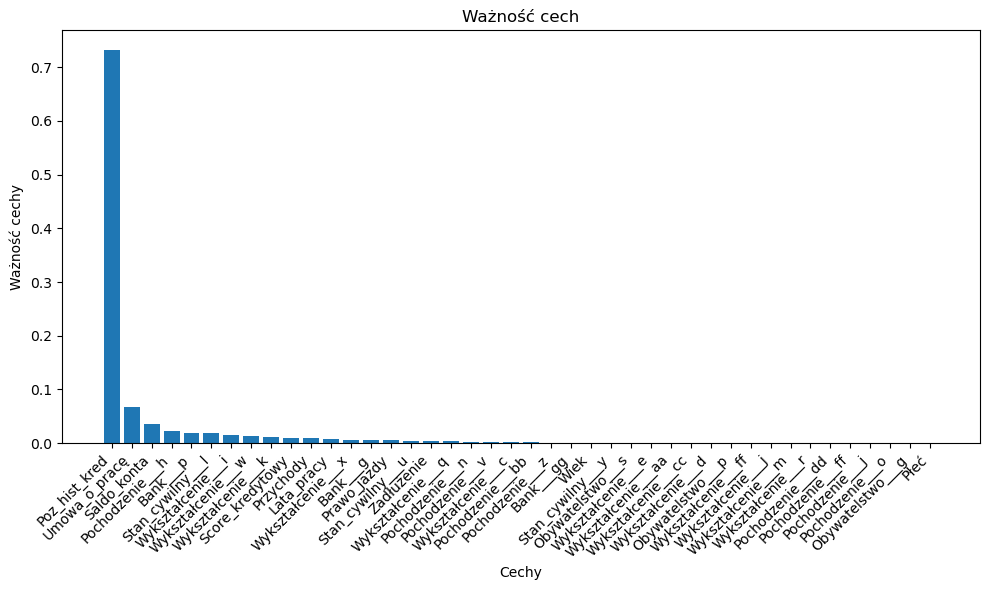

In [319]:
import matplotlib.pyplot as plt
# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.title('Ważność cech')
plt.bar(range(x_tr.shape[1]), feature_importances[indices])
plt.xticks(range(x_tr.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Cechy')
plt.ylabel('Ważność cechy')
plt.tight_layout()
plt.show()

In [320]:
# Filtrowanie cech o ważności powyżej progu
important_features = [(name, importance) 
                      for name, importance in zip(feature_names, feature_importances) 
                      if importance > 0]
important_features

[('Zadłużenie', 0.0038958462254278137),
 ('Lata_pracy', 0.007442644678846938),
 ('Poz_hist_kred', 0.7320467226976524),
 ('Umowa_o_pracę', 0.06698272021113788),
 ('Score_kredytowy', 0.00998023210268238),
 ('Prawo_jazdy', 0.00576982168436325),
 ('Saldo_konta', 0.03547503175494577),
 ('Przychody', 0.008732703089847083),
 ('Stan_cywilny___l', 0.019040671713241628),
 ('Stan_cywilny___u', 0.004341547305755196),
 ('Bank___g', 0.00595411574307756),
 ('Bank___p', 0.0193606530381434),
 ('Wykształcenie___c', 0.001634476150857466),
 ('Wykształcenie___i', 0.01538662841087822),
 ('Wykształcenie___k', 0.010619118172891965),
 ('Wykształcenie___q', 0.003295857144416929),
 ('Wykształcenie___w', 0.01352948501716354),
 ('Wykształcenie___x', 0.006358409232937008),
 ('Pochodzenie___bb', 0.0016124568132087568),
 ('Pochodzenie___h', 0.023034299880383715),
 ('Pochodzenie___n', 0.002568041165147132),
 ('Pochodzenie___v', 0.0017897308161780188),
 ('Pochodzenie___z', 0.0011487869508159628)]

In [321]:
important_features.sort(key=lambda x: x[1], reverse=True)
important_features

[('Poz_hist_kred', 0.7320467226976524),
 ('Umowa_o_pracę', 0.06698272021113788),
 ('Saldo_konta', 0.03547503175494577),
 ('Pochodzenie___h', 0.023034299880383715),
 ('Bank___p', 0.0193606530381434),
 ('Stan_cywilny___l', 0.019040671713241628),
 ('Wykształcenie___i', 0.01538662841087822),
 ('Wykształcenie___w', 0.01352948501716354),
 ('Wykształcenie___k', 0.010619118172891965),
 ('Score_kredytowy', 0.00998023210268238),
 ('Przychody', 0.008732703089847083),
 ('Lata_pracy', 0.007442644678846938),
 ('Wykształcenie___x', 0.006358409232937008),
 ('Bank___g', 0.00595411574307756),
 ('Prawo_jazdy', 0.00576982168436325),
 ('Stan_cywilny___u', 0.004341547305755196),
 ('Zadłużenie', 0.0038958462254278137),
 ('Wykształcenie___q', 0.003295857144416929),
 ('Pochodzenie___n', 0.002568041165147132),
 ('Pochodzenie___v', 0.0017897308161780188),
 ('Wykształcenie___c', 0.001634476150857466),
 ('Pochodzenie___bb', 0.0016124568132087568),
 ('Pochodzenie___z', 0.0011487869508159628)]

In [322]:
# Metoda 1: list comprehension
feature_names = [feature[0] for feature in important_features]
feature_names

['Poz_hist_kred',
 'Umowa_o_pracę',
 'Saldo_konta',
 'Pochodzenie___h',
 'Bank___p',
 'Stan_cywilny___l',
 'Wykształcenie___i',
 'Wykształcenie___w',
 'Wykształcenie___k',
 'Score_kredytowy',
 'Przychody',
 'Lata_pracy',
 'Wykształcenie___x',
 'Bank___g',
 'Prawo_jazdy',
 'Stan_cywilny___u',
 'Zadłużenie',
 'Wykształcenie___q',
 'Pochodzenie___n',
 'Pochodzenie___v',
 'Wykształcenie___c',
 'Pochodzenie___bb',
 'Pochodzenie___z']

In [323]:
# Metoda 2: funkcja map()
feature_names = list(map(lambda x: x[0], important_features))
feature_names

['Poz_hist_kred',
 'Umowa_o_pracę',
 'Saldo_konta',
 'Pochodzenie___h',
 'Bank___p',
 'Stan_cywilny___l',
 'Wykształcenie___i',
 'Wykształcenie___w',
 'Wykształcenie___k',
 'Score_kredytowy',
 'Przychody',
 'Lata_pracy',
 'Wykształcenie___x',
 'Bank___g',
 'Prawo_jazdy',
 'Stan_cywilny___u',
 'Zadłużenie',
 'Wykształcenie___q',
 'Pochodzenie___n',
 'Pochodzenie___v',
 'Wykształcenie___c',
 'Pochodzenie___bb',
 'Pochodzenie___z']

Poniższy kod zawiera dwie pętle, w których:

- pierwsza, to 20 iteracji, w których definiuję dwie listy do zbierania wyników,
- druga, wykona się każdorazowo po 15 razy. Dobieram w niej zmienne do modelu. Pierwsze wykonanie pętli to dobór 5 najlepszych zmiennych, drugie to 6 najlepszych zmiennych, itd.


W pętli numer 2, dla wybranego zestawu zmiennych uczony jest model, z użyciem cross_val_score. W sumie cross_val_score wykona się 300 razy. Dodatkowo w każdej walidacji krzyżowej model jest przecież uczony 10 razy. Mam świadomość, że złożoność obliczeniowa procesu może i nie jest najmniejsza, ale przy tak małym zbiorze, nawet na moim leciwym laptopie całość trwa raptem kilkadziesiąt sekund 🙂

Wszystkie wyniki lądują do list: acc_all i stab_all. W pierwszej z nich zapisywana jest dokładność modelu z wybraną liczbą zmiennych, w drugiej natomiast jego stabilność.

In [324]:
# acc_all = []
# stab_all = []
# for m in np.arange(0,20):
#     stab_loop = []
#     acc_loop = []
# for n in np.arange(5, 20, 1):
#     selector = RFE(model, n, 1)
#     cv = cross_val_score(model, x_tr.iloc[:,selector.fit(x_tr, y_tr).support_], y_tr, cv = 10, scoring = 'accuracy')
#     acc_loop.append(cv.mean())
#     stab_loop.append(cv.std()*100/cv.mean())
# acc_all.append(acc_loop)
# stab_all.append(stab_loop)

# acc = pd.DataFrame(acc_all, columns = np.arange(5, 20, 1))
# stab = pd.DataFrame(stab_all, columns = np.arange(5, 20, 1))
# print(acc.agg(['mean']))
# print(stab.agg(['mean']))

Nazwy kolumn w obu tabelach odnoszą się do liczby zmiennych w modelu. Jeśli przyjrzymy się, to łatwo można dostrzec moment, w którym stabilność znacząco się poprawia. Dokładnie po dodaniu dziewiątej zmiennej stabilność znacząco wzrasta, a Accuracy maleje zaledwie o 0.1%. Decyduję się zatem na 9 zmiennych.

In [325]:
model = DecisionTreeClassifier(**classifier.best_params_, random_state=42)
cv = cross_val_score(model, x_tr[feature_names], y_tr, cv = 10, scoring = 'accuracy')
print('Średnie Accuracy: ' + str(cv.mean().round(3)))
# print('Stabilność: ' + str((cv.std()*100/cv.mean()).round(3)) + '%')

Średnie Accuracy: 0.843


In [327]:
model.fit(x_tr[feature_names], y_tr)
pred = model.predict(x_te[feature_names])
print('Model 3: ' + str(round(accuracy_score(pred, y_te),3)))

Model 3: 0.878


In [216]:
xxx = ['Lata_pracy', 'Poz_hist_kred', 'Umowa_o_pracę', 'Saldo_konta', 'Przychody', 'Stan_cywilny___l', 'Stan_cywilny___y', 'Pochodzenie___ff', 'Pochodzenie___h']

In [221]:
# model.fit(x_tr[xxx], y_tr)
# pred = model.predict(x_te[xxx])
# print('Model 2: ' + str(round(accuracy_score(pred, y_te),3)))

Model 2: 0.878


# Model 4
Opis modelu:

- dobór zmiennych: RFE,
- dobór parametrów: GridsearchCV.

Mając ustalone zmienne zapewniające odpowiednią stabilność i wysoką dokładność, wykonuję dodatkową iterację poszukiwania optymalnych parametrów modelu. Najpierw jednak muszę uruchomić RFE i wybrać 9 najlepszych zmiennych.

# selector = RFE(model, 9, 1)
cols = x_tr.iloc[:,selector.fit(x_tr, y_tr).support_].columns
print(cols)

Zmiennymi, których użyję w finalnym modelu, są:

Lata_pracy,
Poz_hist_kred,
Umowa_o_pracę,
Saldo_konta,
Przychody,
Stan_cywilny___l,
Stan_cywilny___y,
Pochodzenie___ff,
Pochodzenie___h.

Jeśli wrócisz do punktu „Eksploracyjna analiza danych”, to zobaczysz, że część wskazanych tam zależności potwierdza się tutaj. Warto więc robić analizę zależności 🙂

Uruchamiam drugą wersję GridSearchCV, tym razem dla dziewięciu wybranych zmiennych.

In [328]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [329]:
def select_features_rfe(X, y, n_features_to_select=None):
    # Inicjalizacja klasyfikatora DecisionTree
    dt_classifier = DecisionTreeClassifier()
    
    # Utworzenie RFE
    rfe = RFE(
        estimator=dt_classifier, 
        n_features_to_select=n_features_to_select,
        step=1
    )
    
    # Dopasowanie RFE
    rfe.fit(X, y)
    
    # Pobranie nazw wybranych cech
    selected_features = X.columns[rfe.support_].tolist()
    
    # Opcjonalna ocena wybranych cech
    X_selected = X[selected_features]
    cv_scores = cross_val_score(dt_classifier, X_selected, y, cv=5)
    
    return {
        'features': selected_features,
        'cv_scores': cv_scores,
        'mean_score': cv_scores.mean()
    }

In [330]:
result = select_features_rfe(x_tr, y_tr, n_features_to_select=9)
print(result['features'])

['Wiek', 'Zadłużenie', 'Lata_pracy', 'Poz_hist_kred', 'Umowa_o_pracę', 'Saldo_konta', 'Przychody', 'Stan_cywilny___l', 'Stan_cywilny___y']


In [ ]:
# xxx = ['Lata_pracy', 'Poz_hist_kred', 'Umowa_o_pracę', 'Saldo_konta', 'Przychody', 'Stan_cywilny___l', 'Stan_cywilny___y', 'Pochodzenie___ff', 'Pochodzenie___h']

In [331]:
cols = result['features']

In [332]:
classifier2 = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10)
classifier2.fit(x_tr[cols], y_tr)
print(classifier2.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


Finalnie wybrane parametry to:

- criterion: entrophy,
- max_depth: 6,
- min_samples_leaf: 1,
- min_samples_split: 4,
- splitter: random.

Sprawdźmy jeszcze najwyższy wynik, jakiś osiągnął model podczas doboru parametrów.

In [333]:
cv = cross_val_score(DecisionTreeClassifier(**classifier2.best_params_), x_tr[cols], y_tr, cv = 10, scoring = 'accuracy')
print('Średnie Accuracy: ' + str(cv.mean().round(3)))
# print('Stabilność: ' + str((cv.std()*100/cv.mean()).round(3)) + '%')

Średnie Accuracy: 0.862


In [334]:
model = DecisionTreeClassifier(**classifier2.best_params_, random_state=42)
model.fit(x_tr[cols], y_tr)
pred = model.predict(x_te[cols])
print('Finalny wynik to: ' + str(round(accuracy_score(pred, y_te),3)))

Finalny wynik to: 0.885


# Wizualizacja i interpretacja wyników
Udało się uzyskać całkiem fajny rezultat, ale jak interpretować predykcje wyznaczone przez model? Otóż jest na to bardzo prosty sposób. Aby to zrobić, wystarczy posłużyć się schematem drzewa, które można wygenerować z użyciem biblioteki ‚sklearn’.

In [197]:
import graphviz

In [36]:
# import os
# os.environ["PATH"] += os.pathsep + 'D:\Anaconda\Lib\site-packages\graphviz'

In [335]:
dot_data = tree.export_graphviz(model, out_file=None,
feature_names=cols,
class_names=['0','1'],
filled=True, rounded=True,
special_characters=True)
graph = graphviz.Source(dot_data)

Teraz zrobię mały trik i zmienię wielkość wyjściowej grafiki, zmieniając strukturę zmiennej `dot_data`.

In [202]:
# out = dot_data[0:14] + 'ranksep=.75; size = "20,30";' + dot_data[14:]

In [336]:
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('dtree_render',view=True)

'dtree_render.png'

Mając wizualizację drzewa, spróbujmy zatem teraz zinterpretować działanie algorytmu dla trzech przykładowych klientów banku. Losuję zatem ze zbioru testowego trzy osoby. By się nie pogubić w wynikach, posortuję ich po indeksie.

In [337]:
samples = x_te[cols].sample(3).sort_index()
print(samples)

      Wiek  Zadłużenie  Lata_pracy  Poz_hist_kred  Umowa_o_pracę  Saldo_konta  \
157 68.670      15.000       0.000              1              1        0.000   
584 28.080      15.000       0.000              1              0        0.000   
652 22.500       0.415       0.335              0              0      144.000   

     Przychody  Stan_cywilny___l  Stan_cywilny___y  
157       3376                 0                 0  
584      13212                 0                 1  
652          0                 0                 0  


Teraz sprawdźmy, czy ich wnioski zostały zaakceptowane, czy też odrzucone.



In [340]:
y_te

470    0
547    1
679    0
85     0
426    0
      ..
185    1
468    0
43     1
447    0
84     0
Name: Wynik, Length: 131, dtype: uint8

In [342]:
print(y_te[y_te.index.isin(samples.index)].sort_index())

157    1
584    1
652    0
Name: Wynik, dtype: uint8


In [343]:
print(model.predict(samples))

[1 1 0]
